# Light als toyblock multiscanner demo
Notebook: Hannah Weiser & Sina Zumstein, 2023

This demo scene showcases various toyblock models scanned by airborne laserscanning. We will use the command-line access of HELIOS++ to run the simulation, and use Python just for displaying the input XMLs and the resulting point clouds.



In [26]:
import sys, os
from pathlib import Path
from IPython.display import Code

current_folder = globals()["_dh"][0]
helios_path = str(Path(current_folder).parent)
sys.path.append(helios_path)  # add helios-plusplus directory to PATH
import pyhelios

from pyhelios.util.xmldisplayer import display_xml, find_playback_dir

## Survey
Let us look at the XML files in the simulation. First, we investigate the survey XML file, `light_als_toyblocks_multiscanner.xml`:

In [27]:
os.chdir(helios_path)
Code(display_xml(r'data\surveys\demo\light_als_toyblocks_multiscanner.xml'), language='XML')

<document>
	<platformSettings id="platform1" movePerSec_m="30" z="100.0" />
    <scannerSettings active="true" id="scanner1" pulseFreq_hz="10000" scanAngle_deg="20.0" scanFreq_hz="100" trajectoryTimeInterval_s="0.01" />
    <survey name="light_toyblocks_als" platform="data/platforms.xml#sr22" scanner="data/scanners_als.xml#livox-mid-100" scene="data/scenes/toyblocks/light_toyblocks_scene.xml#light_toyblocks_scene">
	
		<leg>
			<platformSettings x="-30.0" y="-50.0" template="platform1" />
			<scannerSettings template="scanner1" />
		</leg>
		<leg>
			<platformSettings x="70.0" y="-50.0" template="platform1" />
			<scannerSettings template="scanner1" active="false" />
		</leg>
		<leg>
			<platformSettings x="70.0" y="0.0" template="platform1" />
			<scannerSettings template="scanner1" />
		</leg>
		<leg>
			<platformSettings x="-30.0" y="0.0" template="platform1" />
			<scannerSettings template="scanner1" active="false" />
		</leg>
	</survey>
</document>

We can see that there are four `leg` elements which define the waypoints of the airplane trajectory and the speed between these waypoints (`movePerSec_m`). This results in three flight lines but on two of them, the laserscanner is active. This is indicated by the parameter `active`. Furthermore, we see that the `sr22` platform in `data/platforms.xml` is referenced, so let's have a look at that next:

# Platform

In [28]:
Code(display_xml(r'data\platforms.xml', 'sr22'))

<platform id="sr22" name="Cirrus SR-22" type="linearpath">
		<scannerMount z="0.7">
			<rot axis="x" angle_deg="-90" />
			<rot axis="z" angle_deg="90" />
		</scannerMount>
		
	</platform>

This is a `linearpath` type platform, a mobile platform which moves in a straight line between consecutive legs with a constant speed provided by the user.

Without any rotations applied to the `scannerMount` in the platform XML or the `beamOrigin` in the scanner XML, scanners in HELIOS would face towards to Y-axis (forward) and scan in vertical scan lines (in the plane created by the Y- and Z-axis). 

For the `sr22`, the `scannerMount` is configured so that the scanner is rotated -90° around the X-axis (facing downwards) and 90° around the Z-axis (scanning from left to right, i.e., in the plane created by the X- and Z-axes).

For more information and examples, check out the [rotations section](https://github.com/3dgeo-heidelberg/helios/wiki/Platforms#rotations) of the Wiki page on platforms.

## Sanner

Next we will have a look at the scanner that is placed on the platform. Here it is the `livox-mid-100` defined in `data/scanners_als.xml` as shown in the survey XML.

In [29]:
Code(display_xml(r'data/scanners_als.xml', 'livox-mid-100'), language='XML')

<scanner id="livox-mid-100" accuracy_m="0.02" beamDivergence_rad="0.0027" name="livox-mid-100" optics="risley" pulseFreqs_Hz="50000" pulseLength_ns="4" rangeMin_m="2" scanAngleMax_deg="35" scanAngleEffectiveMax_deg="35" rotorFreq1_Hz="7294" rotorFreq2_Hz="-4664" wavelength_nm="905">
		<channels>
			<channel id="0">
				<FWFSettings beamSampleQuality="3" />	
				<beamOrigin x="0" y="0" z="0">
					<rot axis="z" angle_deg="-30" /> 
				</beamOrigin>
				
			</channel>
			<channel id="1">
				<FWFSettings beamSampleQuality="3" />
				<beamOrigin x="0" y="0" z="0">
					
				</beamOrigin>
			</channel>
			<channel id="2">
				<FWFSettings beamSampleQuality="3" />
				<beamOrigin x="0" y="0" z="0">
					<rot axis="z" angle_deg="30" /> 
				</beamOrigin>
			</channel>
		</channels>
		<FWFSettings beamSampleQuality="3" />
	</scanner>

Here we can see the scanner-specific settings, for example the `beamDivergence_rad`, the `accuracy` or the possible pulse frequencies (`pulseFreq_Hz`).

## Scene

Now we will have a look at the scene, `light_toyblocks_scene.xml`in `data/scenes/toyblocks/light_toyblocks_scene.xml`:

In [30]:
Code(display_xml(r'data/scenes/toyblocks/light_toyblocks_scene.xml','light_toyblocks_scene'))

<scene id="light_toyblocks_scene" name="LightToyblocksScene">
        <part>
            <filter type="objloader">
                <param type="string" key="filepath" value="data/sceneparts/basic/groundplane/groundplane.obj" />
            </filter>
            <filter type="scale">
                <param type="double" key="scale" value="70" />
            </filter>
			<filter type="translate">
				<param type="vec3" key="offset" value="20.0;0;0" />
			</filter>
        </part>
        <part>
            <filter type="objloader">
                <param type="string" key="filepath" value="data/sceneparts/toyblocks/cube.obj" />
            </filter>
			<filter type="scale">
                <param type="double" key="scale" value="1" />
            </filter>
        </part>
		<part>
            <filter type="objloader">
                <param type="string" key="filepath" value="data/sceneparts/toyblocks/cube.obj" />
            </filter>
			<filter type="rotate">
				<param key="rotation" type="rotation">
					<rot angle_deg="45" axis="z" />
				</param>
			</filter>
			<filter type="scale">
                <param type="double" key="scale" value="0.5" />
            </filter>
			<filter type="translate">
				<param type="integer" key="onGround" value="-1" />
				<param type="vec3" key="offset" value="-45.0;10.0;10" />
			</filter>
        </part>
    </scene>

Here we see two different objects, which are the `groundplane.obj` and the `cube.obj`. To load it we use the `objloader` filter and give the relative path to the file in the `filepath` parameter.

## Executing the Simulation

Next, we will run the simulation. In Jupyter Notebooks, we can run external commands with the `!command` syntax, but you can also just run it from the command line.

In [31]:
!"run/helios.exe" data/surveys/demo/light_als_toyblocks_multiscanner.xml

HELIOS++ VERSION 1.1.1

CWD: "D:\helios"
seed: AUTO
surveyPath: "data/surveys/demo/light_als_toyblocks_multiscanner.xml"
assetsPath: "assets/"
outputPath: "output/"
writeWaveform: 0
calcEchowidth: 0
fullWaveNoise: 0
splitByChannel: 0
parallelization: 1
njobs: 0
chunkSize: 32
warehouseFactor: 4
platformNoiseDisabled: 0
legNoiseDisabled: 0
rebuildScene: 0
lasOutput: 0
las10: 0
fixedIncidenceAngle: 0
gpsStartTime: 
kdtType: 4
kdtJobs: 0
kdtGeomJobs: 0
sahLossNodes: 32

xmlDocFilename: light_als_toyblocks_multiscanner.xml
xmlDocFilePath: data/surveys/demo
xmlDocFilename: scanners_als.xml
xmlDocFilePath: data
Using default value for attribute 'averagePower_w' : 4
Using default value for attribute 'beamQualityFactor' : 1
Using default value for attribute 'opticalEfficiency' : 0.99
Using default value for attribute 'receiverDiameter_m' : 0.15
Using default value for attribute 'atmosphericVisibility_km' : 23
Using default value for attribute 'binSize_ns' : 0.25
Using default value for attribut

## The results 
Now we can display a 3D plot of the simulated point cloud.


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

output_path = find_playback_dir(r"data\surveys\demo\light_als_toyblocks_multiscanner.xml")

print("Loading points from", output_path)

strip_1 = np.loadtxt(Path(output_path) / 'leg000_points.xyz')
strip_2 = np.loadtxt(Path(output_path) / 'leg002_points.xyz')

traj_1 = np.loadtxt(Path(output_path) / 'leg000_trajectory.txt')
traj_2 = np.loadtxt(Path(output_path) / 'leg002_trajectory.txt')

traj = np.vstack((traj_1[:, :3], traj_2[:, :3]))

Loading points from D:\helios\output\light_toyblocks_als\2023-01-08_19-10-06


In [33]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius]) 
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

In [35]:
print(strip_1)

[[ 8.95635000e+01 -4.88634000e+01  3.66000000e-02 ...  0.00000000e+00
   0.00000000e+00  6.53970000e+04]
 [ 8.84599000e+01 -4.77695000e+01 -3.75000000e-02 ...  0.00000000e+00
   0.00000000e+00  6.53970001e+04]
 [ 3.33326000e+01 -4.62940000e+01  1.98442000e+01 ...  1.00000000e+00
   0.00000000e+00  6.53970011e+04]
 ...
 [ 1.61524000e+01 -6.11780000e+01  5.80000000e-03 ...  0.00000000e+00
   0.00000000e+00  6.54003264e+04]
 [ 1.78233000e+01 -6.43717000e+01  1.65000000e-02 ...  0.00000000e+00
   0.00000000e+00  6.54003265e+04]
 [ 1.95565000e+01 -6.73557000e+01  7.10000000e-03 ...  0.00000000e+00
   0.00000000e+00  6.54003266e+04]]


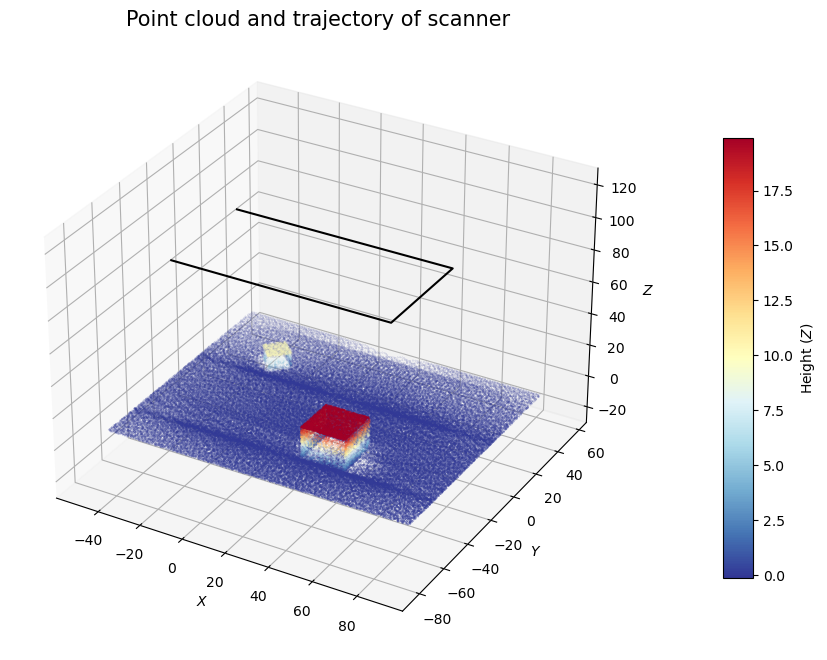

In [41]:
# Matplotlib figure.
fig = plt.figure(figsize=(12,8))
# Axes3d axis onto mpl figure.
ax = fig.add_subplot(projection='3d')


# Scatter plot of points (coloured by height).
sc = ax.scatter(strip_1[:, 0], strip_1[:, 1], strip_1[:, 2], c=strip_1[:, 2], cmap="RdYlBu_r", s=0.02, label='scene')
sc = ax.scatter(strip_2[:, 0], strip_2[:, 1], strip_2[:, 2], c=strip_2[:, 2], cmap="RdYlBu_r", s=0.02, label='scene')

# Plot of trajectory.
ax.plot(traj[:,0], traj[:,1], traj[:,2], c = 'black', label = 'scanner trajectory')

cax = plt.axes([0.85, 0.2, 0.025, 0.55])

cbar = plt.colorbar(sc, cax=cax)

cbar.set_label("Height $(Z)$")

# Add axis labels.
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_zlabel('$Z$')


set_axes_equal(ax)    

# Set title.
ax.set_title(label='Point cloud and trajectory of scanner',fontsize=15)
# Set subtitle.


# Display results
plt.show()